# IMERG FINAL - Precipitation Data
 - **@author**: Mario Garcia (mario.garcia@utec.edu.uy)
 - **@description**: Procesamiento de los datos RAW de las estimaciones de precipitacion del producto satelital.  
 - **Data Source**:  https://gpm.nasa.gov/data/imerg
 - **Output**: 
  - **imerg_final_daily_2000_2020.nc** (Dataset netCDF unificado de las celdas imerg_final con los geodatos de latitud y longitud)
  - mater_imerg_final_daily_2000_2020.nc (Dataset netCDF imerg_final_daily_2000_2020.nc que ha pasado control de calidad y puede ser utilizado para la próxima etapa)

 - **Input**: 
      - master_data_raw_imerg_final.tar.gz (netCDF con datos raw de las estimaciones de precipitacion del producto satelital) 
 - **@version**: v1.3
 - **@date**: 2022-08-10,  2022-08-06, 2022-08-01, 2022-07-30, 2022-07-26   


## Setup

In [ ]:
dir_google_drive = "/content/drive/MyDrive/ValidacionProductosSatelitales(VPS)/Proyecto Colab/03 - DataLake/"
dir_google_drive_output = dir_google_drive+'/datasets/output/'
dir_data = './data/'
dir_data_source = dir_data+'/source/'
dir_var = './var/'
dir_download = dir_var+'/download/'
dir_output = dir_var+'/output/'
dir_log = dir_var+'/log/'


### Libraries

In [ ]:
!pip install geopandas 

In [ ]:
# Data
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# Utils
import os 
# import shutil
import glob

# Zip
import zipfile

# NetCDF
import xarray  as xr

# GEO MAPS
# https://jcutrer.com/python/learn-geopandas-plotting-usmaps
import geopandas as gpd
from shapely.geometry import Point, Polygon


In [ ]:
def get_geometry_uruguay():
  df_world_shapes = gpd.read_file(dir_data+"/TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shp")
  df_uruguay_shapes = df_world_shapes[ df_world_shapes['ISO2'] == 'UY']
  # df_uruguay_shapes
  polygon_uruguay = df_uruguay_shapes['geometry']
  return polygon_uruguay
  # polygon_uruguay = geometry[210]
  # return gpd.GeoSeries(polygon_uruguay)

### Init

In [ ]:
!rm -rf "$dir_data"

!mkdir -p "$dir_data"
!mkdir -p "$dir_data_source"
!mkdir -p "$dir_download"
!mkdir -p "$dir_output"
!mkdir -p "$dir_log"

!mkdir -p "$dir_data"/TM_WORLD_BORDERS
!wget  -O "$dir_download"/TM_WORLD_BORDERS-0.3.zip  http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip 
!unzip -o "$dir_download"/TM_WORLD_BORDERS-0.3.zip -d "$dir_data"/TM_WORLD_BORDERS 


## Download Data

In [ ]:
# %%bash
# # https://daac.gsfc.nasa.gov/data-access#windows_wget
# cat > /root/.netrc << EOF
# machine urs.earthdata.nasa.gov login mariogarcia.ar password ***
# machine gpm1.gesdisc.eosdis.nasa.gov login mariogarcia.ar password ***
# EOF
# chmod 0600 /root/.netrc
# touch /root/.urs_cookies


In [ ]:
# %%bash
# mkdir -p /content/data
# cd /content/data
# mkdir -p /content/logs

# wget  --load-cookies /root/.urs_cookies \
#       --save-cookies /root/.urs_cookies \
#       --auth-no-challenge=on \
#       --keep-session-cookies \
#       -P /content/data \
#       -b --no-clobber --continue --wait=1 \
#       -o /content/logs/wget.log \
#       -i "/content/data/download.txt"  

In [ ]:
# Hack de performance

# Son 7500 archivos para procesar. Y dado que el servicio que ofrece IMERG es muy lento, 
#         creamos un backup de los archivos y utilizamos el mismo para el procesamiento.
!gdown -O "$dir_download"/master_data_raw_imerg_final.tar.gz "1g2xgGq5Sou0rBGMorem7jl2cp-KHNmKw"

!tar -xvzf "$dir_download"/master_data_raw_imerg_final.tar.gz  -C "$dir_data_source"

!mv "$dir_data_source"/data_final/*  "$dir_data_source"/
!rm "$dir_download"/data_final/


In [ ]:
import glob
# rename files
files = glob.glob(f"{dir_data_source}/*nc4*")
for f in files:
  file = f.split('.nc4?')
  os.rename(f, file[0])

## Config

In [ ]:
var_lat = 'lat'
var_lon = 'lon'
var_time = 'time'
var_precipitation = 'precipitationCal'

var_null_values = -598

var_null_values_from_source = -9999.9    #Validate

## Process Data

In [ ]:
pattern = dir_data_source+'/*.nc4'
ds_xr_multi = xr.open_mfdataset(pattern,chunks={var_lat: 100, var_lon: 100,var_time: '1GB'})
ds_xr_multi

<xarray.Dataset>
Dimensions:           (time: 7519, lon: 61, lat: 51)
Coordinates:
  * lat               (lat) float32 -35.05 -34.95 -34.85 ... -30.15 -30.05
  * lon               (lon) float32 -58.95 -58.85 -58.75 ... -53.05 -52.95
  * time              (time) object 2000-06-01 00:00:00 ... 2020-12-31 00:00:00
Data variables:
    precipitationCal  (time, lon, lat) float32 dask.array<chunksize=(1, 61, 51), meta=np.ndarray>
Attributes:
    BeginDate:       2000-06-01
    BeginTime:       00:00:00.000Z
    EndDate:         2000-06-01
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2000-06-01T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B....
    title:           GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 ...
    DOI:             10.5067/GPM/IMERGDF/DAY/06
    ProductionTime:  2019-06-18T20:51:50.167Z
    history:         2022-07-26 07:16:09 GMT Hyrax-1.16.3 https://gpm1.gesdis...

In [ ]:
ds_xr_multi[var_precipitation].data

dask.array<concatenate, shape=(7519, 61, 51), dtype=float32, chunksize=(1, 61, 51), chunktype=numpy.ndarray>

### Standarize

In [ ]:
names = {var_time:'time', var_precipitation:'precipitation', var_lat:'lat', var_lon:'lon'}
ds_xr_multi = ds_xr_multi.rename(names)
ds_xr_multi

<xarray.Dataset>
Dimensions:        (time: 7519, lon: 61, lat: 51)
Coordinates:
  * lat            (lat) float32 -35.05 -34.95 -34.85 ... -30.25 -30.15 -30.05
  * lon            (lon) float32 -58.95 -58.85 -58.75 ... -53.15 -53.05 -52.95
  * time           (time) object 2000-06-01 00:00:00 ... 2020-12-31 00:00:00
Data variables:
    precipitation  (time, lon, lat) float32 dask.array<chunksize=(1, 61, 51), meta=np.ndarray>
Attributes:
    BeginDate:       2000-06-01
    BeginTime:       00:00:00.000Z
    EndDate:         2000-06-01
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2000-06-01T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B....
    title:           GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 ...
    DOI:             10.5067/GPM/IMERGDF/DAY/06
    ProductionTime:  2019-06-18T20:51:50.167Z
    history:         2022-07-26 07:16:09 GMT Hyrax-1.16.3 https://gpm1.gesdis...

In [ ]:
ds_xr_multi = ds_xr_multi[['precipitation']]
ds_xr_multi

<xarray.Dataset>
Dimensions:        (time: 7519, lon: 61, lat: 51)
Coordinates:
  * lat            (lat) float32 -35.05 -34.95 -34.85 ... -30.25 -30.15 -30.05
  * lon            (lon) float32 -58.95 -58.85 -58.75 ... -53.15 -53.05 -52.95
  * time           (time) object 2000-06-01 00:00:00 ... 2020-12-31 00:00:00
Data variables:
    precipitation  (time, lon, lat) float32 dask.array<chunksize=(1, 61, 51), meta=np.ndarray>
Attributes:
    BeginDate:       2000-06-01
    BeginTime:       00:00:00.000Z
    EndDate:         2000-06-01
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2000-06-01T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B....
    title:           GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 ...
    DOI:             10.5067/GPM/IMERGDF/DAY/06
    ProductionTime:  2019-06-18T20:51:50.167Z
    history:         2022-07-26 07:16:09 GMT Hyrax-1.16.3 https://gpm1.gesdis...

In [ ]:
ds_xr_multi['precipitation'] = ds_xr_multi['precipitation'].astype(np.float32)
ds_xr_multi['lat'] = ds_xr_multi['lat'].astype(np.float32)
ds_xr_multi['lon'] = ds_xr_multi['lon'].astype(np.float32)
ds_xr_multi

<xarray.Dataset>
Dimensions:        (time: 7519, lon: 61, lat: 51)
Coordinates:
  * lat            (lat) float32 -35.05 -34.95 -34.85 ... -30.25 -30.15 -30.05
  * lon            (lon) float32 -58.95 -58.85 -58.75 ... -53.15 -53.05 -52.95
  * time           (time) object 2000-06-01 00:00:00 ... 2020-12-31 00:00:00
Data variables:
    precipitation  (time, lon, lat) float32 dask.array<chunksize=(1, 61, 51), meta=np.ndarray>
Attributes:
    BeginDate:       2000-06-01
    BeginTime:       00:00:00.000Z
    EndDate:         2000-06-01
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2000-06-01T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B....
    title:           GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 ...
    DOI:             10.5067/GPM/IMERGDF/DAY/06
    ProductionTime:  2019-06-18T20:51:50.167Z
    history:         2022-07-26 07:16:09 GMT Hyrax-1.16.3 https://gpm1.gesdis...

### Filtre

In [ ]:
# replace all missing values with -999
mask = (ds_xr_multi['precipitation'] == var_null_values_from_source)
ds_xr_multi['precipitation'] = xr.where(mask, var_null_values, ds_xr_multi['precipitation'])
ds_xr_multi_query = ds_xr_multi

In [ ]:
# Uruguay box
lat_max = -30; lat_min = -35
lon_max = -53; lon_min = -59

ds_xr_multi_query = ds_xr_multi_query.where(ds_xr_multi_query['lat'] < lat_max, drop=True)
ds_xr_multi_query = ds_xr_multi_query.where(ds_xr_multi_query['lat'] > lat_min, drop=True)

ds_xr_multi_query = ds_xr_multi_query.where(ds_xr_multi_query['lon'] < lon_max, drop=True)
ds_xr_multi_query = ds_xr_multi_query.where(ds_xr_multi_query['lon'] > lon_min, drop=True)

In [ ]:
ds_xr_multi_query_done = ds_xr_multi_query.compute()
ds_xr_multi_query_done

<xarray.Dataset>
Dimensions:        (time: 7519, lon: 60, lat: 50)
Coordinates:
  * lat            (lat) float32 -34.95 -34.85 -34.75 ... -30.25 -30.15 -30.05
  * lon            (lon) float32 -58.95 -58.85 -58.75 ... -53.25 -53.15 -53.05
  * time           (time) object 2000-06-01 00:00:00 ... 2020-12-31 00:00:00
Data variables:
    precipitation  (time, lon, lat) float32 0.01109 0.0 0.0 ... 9.388 4.74 1.645
Attributes:
    BeginDate:       2000-06-01
    BeginTime:       00:00:00.000Z
    EndDate:         2000-06-01
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2000-06-01T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B....
    title:           GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 ...
    DOI:             10.5067/GPM/IMERGDF/DAY/06
    ProductionTime:  2019-06-18T20:51:50.167Z
    history:         2022-07-26 07:16:09 GMT Hyrax-1.16.3 https://gpm1.gesdis...

## Export

In [ ]:
encoding = {'precipitation': {
                  #'_FillValue': var_null_values,      NOT SUPPORTED by xArray
                  #'missing_value': var_null_values,   NOT SUPPORTED by xArray
                  # 'chunksizes': (1, 8, 10),
                  'complevel': 9,
                  'zlib': True}
            }            
file_nc = dir_output+'/imerg_final_daily_2000_2020.nc'
ds_xr_multi_query_done.to_netcdf(file_nc,mode="w", encoding=encoding)

In [ ]:
# Export to drive (optional)
!cp "$file_nc" "$dir_google_drive_output" 

## Plot

In [ ]:
file_nc = dir_google_drive_output+'/imerg_final_daily_2000_2020.nc' 

df_xr_raw = xr.open_dataset(file_nc) # !Important for Null Values
# !Important
mask = df_xr_raw.precipitation > 0
df_xr = df_xr_raw.where( mask )

# df_xr = xr.open_dataset(file_nc, mask_and_scale=True) # !Important for Null Values -598
# df_xr


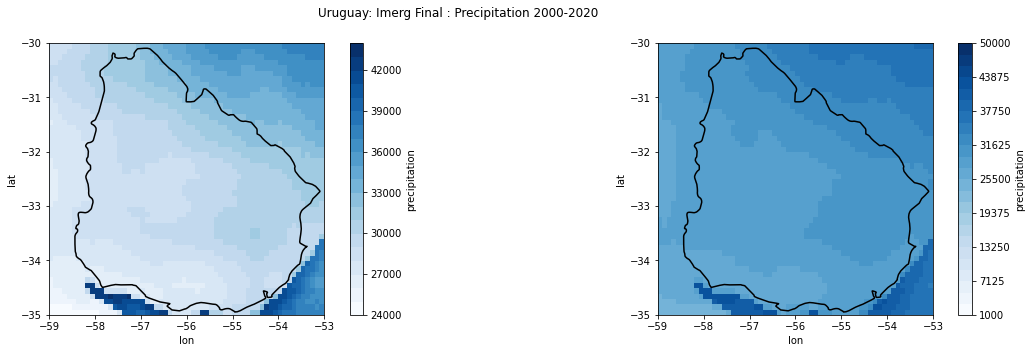

In [ ]:
# coordinate reference system
crs={'init':'epsg:4326'}

geodf_shape = get_geometry_uruguay()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))  

df_xr_acc = df_xr.sum(dim="time")['precipitation']


df_xr_acc.plot(ax=axs[0], x="lon", y="lat", cmap="Blues", levels=20)
geodf_shape.boundary.plot(ax=axs[0], color="black")

df_xr_acc.plot(ax=axs[1], x="lon", y="lat", cmap="Blues", levels=np.linspace(1000, 50000, 25))
geodf_shape.boundary.plot(ax=axs[1], color="black")

prec_max = np.round(float(df_xr_acc.max().data), 2)
prec_min = np.round(float(df_xr_acc.min().data), 2)
fig.suptitle(f'Uruguay: Imerg Final : Precipitation 2000-2020', fontsize=12)
plt.show()